In [1]:
# Andrew Dunn, Katherine Dumais, Kathryn Link-Oberstar, Lee-Or Bentovim
# Summary of initial feature engineering and model testing for checkpoint 2

# This analysis runs after we load, clean, and generate additional variables in load_data.py, 
# and initially explored the data in exploratory_analysis.ipynb.

In [2]:
# Import libraries and data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.feature_selection import RFE

import load_data
from evaluate_classification import evaluate_classification
SEED = 0

In [3]:
# Pull the different dataframes

# raw cleaned data
df, X_valid, y_valid = load_data.load_train_data()
X = df.iloc[:, :-1]
y = df.loc[:, 'Target']

# Create oversampled dataframes
train_X_resampled, train_y_resampled = load_data.gen_oversample_date()
X_smote, y_smote = load_data.gen_SMOTE_data()

**Feature Engineering**

We generate several new variables, derived from our literature review, in load_data.py:

- max_education_level: the education level of the person with the highest education level in the household
- hh_has_marriage: whether someone in the household is married
- hh_max_age: the age of the oldest person in the household
- hh_sex_ratio: the ratio of men to women in the household
- hh_child_woman_ratio_12: the ratio of children to women in the household, with children defined as being under 12
- hh_child_adult_ratio_12: the ratio of children to adults in the household, with children defined as being under 12
- hh_child_woman_ratio_19: the ratio of children to women in the household, with children defined as being under 19
- hh_child_adult_ratio_19: the ratio of children to adults in the household, with children defined as being under 19
- v2a1_log: the logged value of v2a1, the monthly rent payment. We also estimate and impute values into v2a1 when that field is missing.

**Model Testing**

We tested variations of four different models: random forest, naive bayes, KNN, and logistic regression in the following notebooks:

Below, we demonstrate the best performing variants of those models.

Accuracy: 0.66
F1 Score: 0.59
Recall: Label 1: 0.16 Label 2: 0.28 Label 3: 0.03 Label 4: 0.94


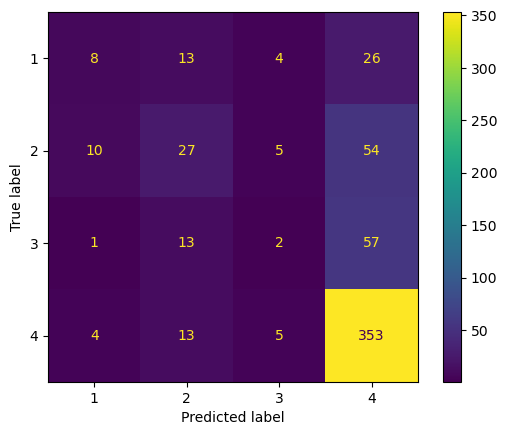

In [4]:
# Random Forest
clf = RandomForestClassifier(random_state = SEED,
                            n_estimators = 1600,
                            min_samples_split = 2,
                            min_samples_leaf = 1,
                            max_features = 'sqrt',
                            max_depth = 100,
                            bootstrap = False
)
clf.fit(X, y)

y_pred = clf.predict(X_valid)
evaluate_classification(y_pred, y_valid, cm = True)

In [5]:
# Naive Bayes

In [6]:
# KNN

*Logistic Regression*\
The goal of logistic regression is to find the best parameters of a logistic function that minimizes the difference between the predicted probabilities and the actual outcomes. The logistic function uses the sigmoid function, which maps any real number into a range between 0 and 1, allowing us to interpret the output as a probability. The input features are weighted and combined linearly, and the resulting value is passed through the logistic function to produce a probability. We then use gradient descent to determine what the best classification is for these categories. Regularization helps to improve the generalization performance of the model by balancing the bias-variance trade-off and reducing overfitting.  By penalizing the weights of the input features, regularization encourages the model to focus on the most important features that are most relevant to the target variable. Overfitting occurs when a model learns to fit the training data too closely, including noise and irrelevant features, leading to poor generalization performance on new, unseen data. In this case we will try L2 regularization which adds a penalty term proportional to the square of the weights.

One drawback however, is that it assumes linear relationships which based on the diversity of our data, may not be true in this case. 

With Smote- RFE
Accuracy: 0.4
F1 Score: 0.42
Recall: Label 1: 0.0 Label 2: 0.77 Label 3: 0.11 Label 4: 0.42
With Random Selection- RFE
Accuracy: 0.34
F1 Score: 0.33
Recall: Label 1: 0.0 Label 2: 0.95 Label 3: 0.0 Label 4: 0.29
With Smote- Variance Threshold
Accuracy: 0.58
F1 Score: 0.59
Recall: Label 1: 0.2 Label 2: 0.26 Label 3: 0.19 Label 4: 0.79
With Random Selection-Variance threshold
Accuracy: 0.52
F1 Score: 0.56
Recall: Label 1: 0.49 Label 2: 0.32 Label 3: 0.26 Label 4: 0.63


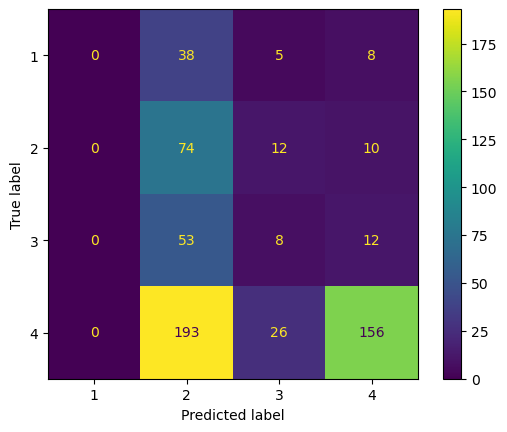

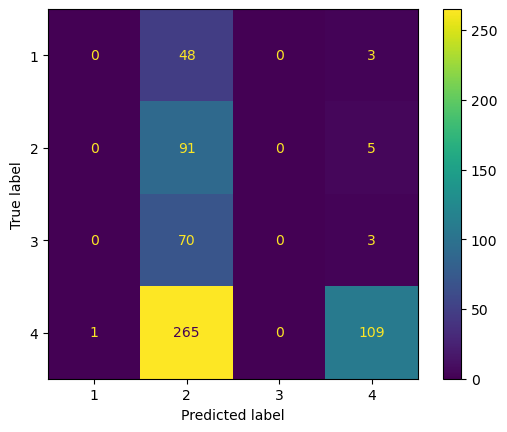

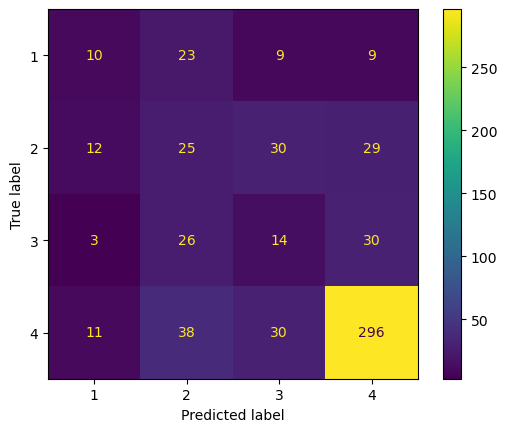

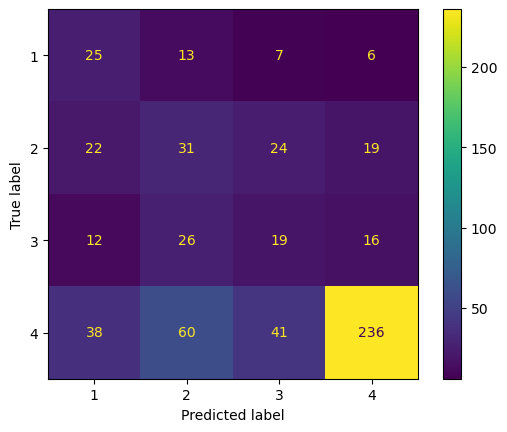

In [9]:
# Logistic Regression

#Train our data with two oversampling methods: SVM SMOTE and random sampling with replacement 

print("With Smote- RFE")
#Recursive feature elimination
rfe = RFE(estimator=LogisticRegression(solver='liblinear', penalty='l2'),n_features_to_select = 5, step = 1)
rfe.fit(X_smote, y_smote)
y_pred = rfe.predict(X_valid)
evaluate_classification(y_pred, y_true = y_valid, labels=[1,2,3,4], cm = True)

#X_train.iloc[:,[138, 126, 127, 108, 107]]

print("With Random Selection- RFE")
#Recursive feature elimination
rfe = RFE(estimator=LogisticRegression(solver='liblinear', penalty='l2'),n_features_to_select = 5, step = 1)
rfe.fit(train_df_resampled, train_y_resampled)
y_pred = rfe.predict(X_valid)
evaluate_classification(y_pred, y_true = y_valid, labels=[1,2,3,4], cm = True)


print("With Smote- Variance Threshold")
# get rid of features without a lot of variance 
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
a= X_smote.copy()
rev_x = sel.fit_transform(a)
reg = LogisticRegression(solver='liblinear', penalty='l2').fit(rev_x, y_smote)

y_pred = reg.predict(sel.transform(X_valid.copy()))
evaluate_classification(y_pred, y_true = y_valid, labels=[1,2,3,4], cm = True)

print("With Random Selection-Variance threshold")

# get rid of features without a lot of variance 
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
rev_x = sel.fit_transform(train_df_resampled.copy())
reg = LogisticRegression(solver='liblinear', penalty='l2').fit(rev_x, train_y_resampled)
a= X_valid.copy()
y_pred = reg.predict(sel.transform(a))
evaluate_classification(y_pred, y_true = y_valid, labels=[1,2,3,4], cm = True)


While, if we reference the logistic regression function, without overweighting we only classify the majority class 4 (please see regression document). With overweighting and feature selection methods, we get our best predictors using regularized logistic regression in terms of classification accuracy and F1 score. But given the diversity of the results, it is clear feature selection as opposed to logistic regression usage is the most important part of this work. It is unclear if regularized logistic regression will be the best indicator going forward.

** Discussion **

** Next Steps **